**Google has been tracking your footsteps.**

In case you don't know already, google knows where you have been since you have started carrying a mobile device (unless of course you [turned off Location History](https://support.google.com/accounts/answer/3118687)).

Some people might feel uncomfortable with the big brother watching them. I feel pretty ok with that. It feels safe to know that wherever I go, Google watches me; if I'm lost, Google knows where I am and can send a rescue mission. Go Google!

Anyhow, in case you want to know what google knows about you, you can download your Location History data from [https://www.google.com/settings/takeout](https://www.google.com/settings/takeout).

I downloaded mine and started exploring the data. It would be nice to see if we can get some insights from it.

The basic imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap

import json
from pandas.io.json import json_normalize

%matplotlib inline
rcParams['figure.figsize'] = (20, 3)

First thing, we'll load the data from the downloaded json file.

In [2]:
data = json_normalize(json.load(open('LocationHistory.json', 'r'))['locations'])
data.head()

,accuracy,activitys,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,26,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,320796661,347841758,1475514329219,NaN,NaN
1,20,NaN,NaN,NaN,320797239,347841462,1475514261172,NaN,NaN
2,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,320797239,347841462,1475514141123,NaN,NaN
3,20,NaN,NaN,NaN,320797239,347841462,1475514008682,NaN,NaN
4,20,"[{u'activities': [{u'confidence': 75, u'type':...",NaN,NaN,320797365,347841623,1475513948078,NaN,NaN


In [3]:
print 'available data:', ' to '.join(map(lambda t: str(pd.to_datetime(int(t) * 1000000).date()),
                                         [data.timestampMs.min(), data.timestampMs.max()]))

available data: 2013-02-18 to 2016-10-03


In [4]:
data['longitude'] = data.longitudeE7 / 10000000
data['latitude'] = data.latitudeE7 / 10000000
data.drop(['longitudeE7', 'latitudeE7'], axis=1, inplace=True)

The first thing crying out to be done is to plot all the locations I've been to.

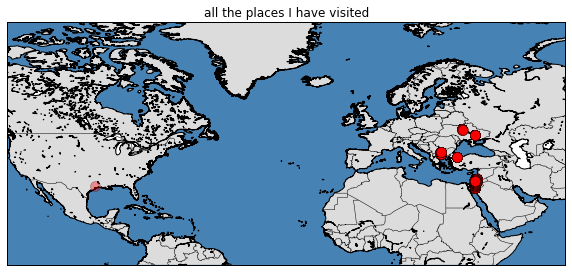

In [5]:
def plot_places(data, title, padding, markersize):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    m = Basemap(projection='gall',
                llcrnrlon=data.longitude.min() - padding,
                llcrnrlat=data.latitude.min() - padding,
                urcrnrlon=data.longitude.max() + padding,
                urcrnrlat=data.latitude.max() + padding,
                resolution='h',
                area_thresh=100)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='gainsboro')
    m.drawmapboundary(fill_color='steelblue')
    x, y = m(data.longitude.values, data.latitude.values)
    m.plot(x, y, 'o', c='r', markersize=markersize, alpha=0.2)
    
plot_places(data=data, title='all the places I have visited', padding=30, markersize=10)

I've been abroad a couple of times. But obviously most of the time I've been in my own country, so let's visualize that:

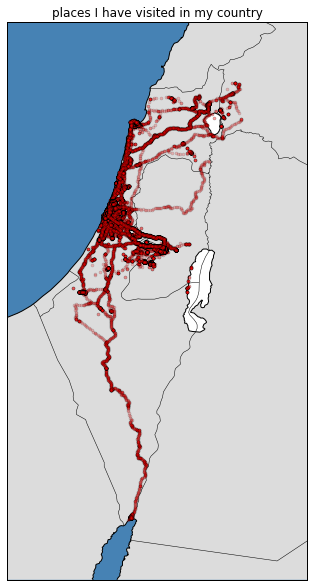

In [6]:
radius = 3
country_data = data[((data.longitude - data.longitude.median()).abs() <= radius) &
                    ((data.latitude - data.latitude.median()).abs() <= radius)]
plot_places(data=country_data,
            title='places I have visited in my country',
            padding=0.5,
            markersize=3)

In order to find my country data I just used the median location (using the mean won't do good here, since other countries I've visited are outliers and will influence it).

Choosing `radius` to be 3 was done empirically so we can get the whole country in the plot.

In case you don't recognize, that's Israel. Most of my locations mass is in Tel-Aviv and Jerusalem. That's pretty reasonable, since I used to live in Jerusalem before I moved to Tel Aviv. Additionally, my parents live in Jerusalem, so it's expected that I'll visit them occasionally.

---

An interesting question to ask is how often do I visit my parents. Since I moved out of Jerusalem, it isn't reasonable to expect me to visit them more frequently than once a week. But let's be realistic: once a week might be too much. Once a month however will make me look like a bad son...

Let's analyze that! First, we'll mark the samples located inside Jerusalem.

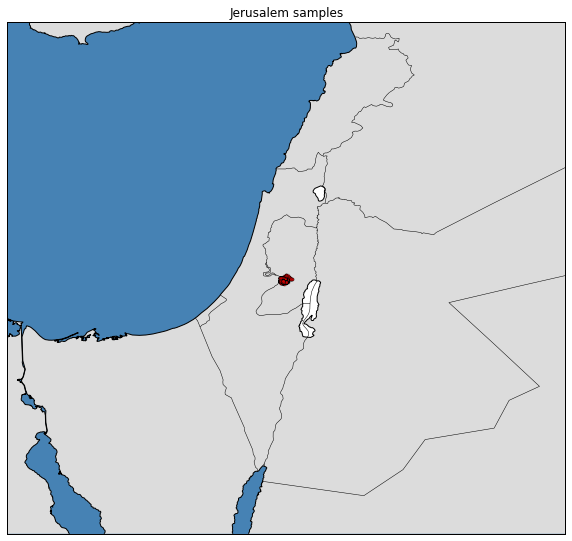

In [7]:
data['is_jerusalem'] = ((data.longitude >= 35.148037) &
                        (data.longitude <= 35.288230) &
                        (data.latitude >= 31.724724) &
                        (data.latitude <= 31.831740))
plot_places(data=data[data.is_jerusalem],
            title='Jerusalem samples',
            padding=3,
            markersize=3)

I didn't perform a precise query of the samples located inside Jerusalem. I selected the points inside some rectangular that contains Jerusalem (I just selected the rectangle's points using Google Maps). It's sufficient for our analysis, since whenever I've been inside the rectangle it has to be that I visited Jerusalem in the same day (since I have no other place to visit in the area). This rectangle defines a cut in the map with a good enough separation of *Jerusalem* and *non-Jerusalem* points.

Next thing, we'll convert the index into `DatetimeIndex` so it'll be easier for us to do time series manipulations.

In [8]:
data = data.set_index(pd.to_datetime(data.timestampMs.map(int) * 1000000)).drop('timestampMs', axis=1)
data.index.name = 'time'
data.head()

,accuracy,activitys,altitude,heading,velocity,verticalAccuracy,longitude,latitude,is_jerusalem
time,,,,,,,,,
2016-10-03 17:05:29.219,26,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,NaN,NaN,34.784176,32.079666,False
2016-10-03 17:04:21.172,20,NaN,NaN,NaN,NaN,NaN,34.784146,32.079724,False
2016-10-03 17:02:21.123,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,NaN,NaN,34.784146,32.079724,False
2016-10-03 17:00:08.682,20,NaN,NaN,NaN,NaN,NaN,34.784146,32.079724,False
2016-10-03 16:59:08.078,20,"[{u'activities': [{u'confidence': 75, u'type':...",NaN,NaN,NaN,NaN,34.784162,32.079737,False


Now we can easily mark the days in which I've visited Jerusalem.

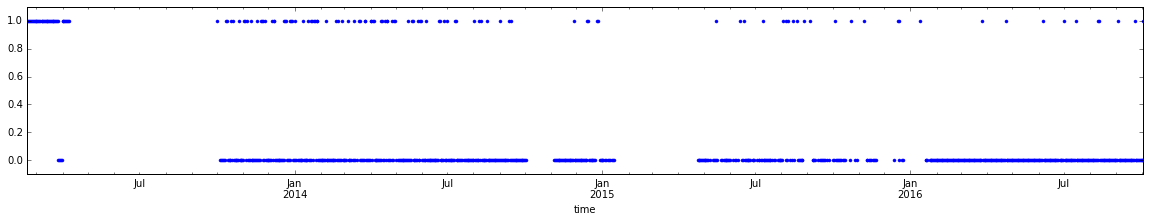

In [9]:
is_jerusalem_daily = data.is_jerusalem.resample('D').max()
plt.ylim((-0.1, 1.1))
is_jerusalem_daily.plot.line(style='.')

There's a lot of missing data, but we'll make the best out of what we've got...

We can see two behavioural transitions:
* It seems that before April 2013 I've always been in Jerusalem. That's because my wife and I moved out of Jerusalem to Tel-Aviv at around June 2013.
* It seems like the frequency of the visits has changed sometime during 2015 (the *Jerusalem* dots seem less dense). We'll come back to that later.

Let's better visualize this data: for every day, we want to know how many days have passed since the last visit to Jerusalem.

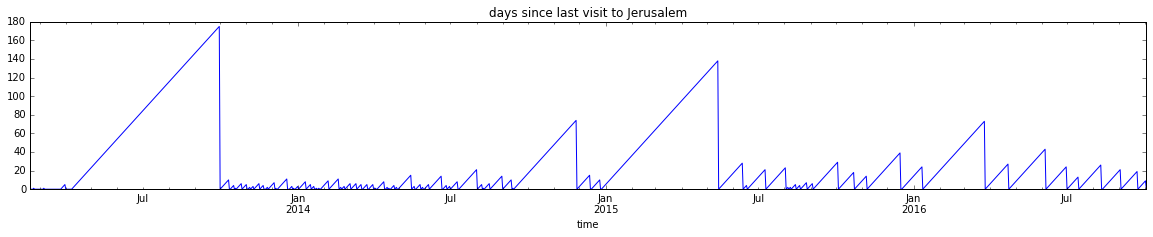

In [10]:
def count_days_since_most_recent_marker(marked_data):
    '''
    marked_data marks some of data's days. The i'th day is marked
    if marked_data's i'th cell is evaluated to True.
    Return a time series in which every day contains the number
    of days passed since the most recent marked day.
    If a day is marked, the result for that day will be 0.
    '''
    # put NAN in the non-marked days, and 1 in the marked days
    marked_data = marked_data.map(lambda d: 1 if d else np.nan)
    # multiply each marked day by the day's index
    marked_data *= xrange(len(marked_data))
    # 'ffill' will propagate last non-NAN value forward to NAN values.
    # This way, every entry will contain the index of the last non-NAN entry
    marked_data.fillna(method='ffill', inplace=True)
    # translate indices to dates
    marked_data = marked_data.map(lambda i: marked_data.index[int(i)])
    # calculate the time delta between every day to its most recent marked day
    marked_data = marked_data.index - marked_data
    # extract the days component
    marked_data = marked_data.map(lambda timedelta: timedelta.days)
    return marked_data
    
days_since_last_visit = count_days_since_most_recent_marker(is_jerusalem_daily == 1)
plt.ylim((0, days_since_last_visit.max() + 5))
plt.title('days since last visit to Jerusalem')
days_since_last_visit.plot()

This graph contains some high values. But let's not forget: we have missing data, e.g. in the period between April 2013 and October 2013. The missing data was treated as non-Jerusalem days. Plotting the missing data periods, we get:

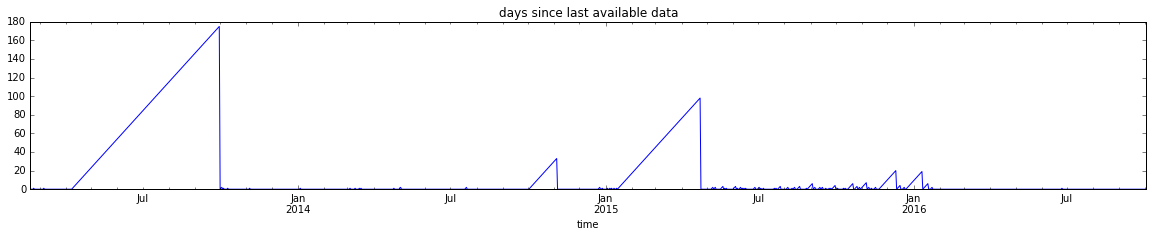

In [11]:
days_since_last_available_data = count_days_since_most_recent_marker(is_jerusalem_daily.notnull())
plt.ylim((0, days_since_last_available_data.max() + 5))
plt.title('days since last available data')
days_since_last_available_data.plot()

It seems like besides the long periods of missing data, there are short periods (even of one day) of missing data.

This analysis is aimed at proving (or failing to prove) that I visit Jerusalem in a satisfactory manner. It's like a trial: if there's no data to convict me then I'm free of charge. I'll regard the long missing data periods as such, meaning: they won't be counted as non-Jerusalem days (since most probably I *have* been in Jerusalem a copule of times in those periods). The short periods on the other hand are too short for me to make the same claim, so I'll treat tham as no-Jerusalem days.
I'll define short periods to be periods of less than a week:

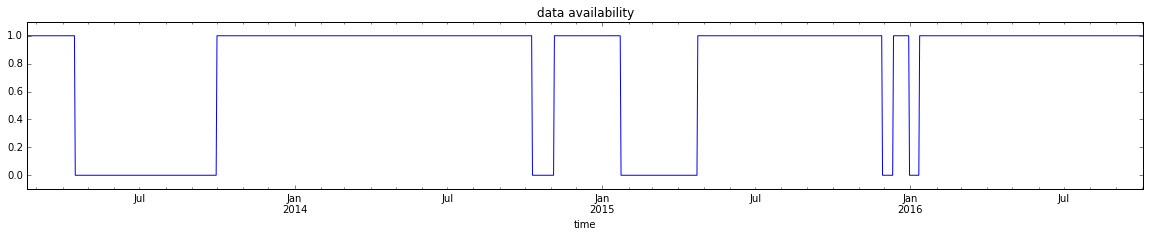

In [12]:
data_availability = days_since_last_available_data <= 7
plt.figure()
plt.ylim(-0.1, 1.1)
plt.title('data availability')
data_availability.plot()

`data_availability` is a less noisy version of `days_since_last_available_data`.

In order to discard the long periods with no data, we'll first find the points in time where data starts to be available, i.e. - switch points from `False` to `True`:

In [13]:
data_availability_shifted = data_availability.shift(1).fillna(True)
availability_on_switch = ((data_availability_shifted == False) & (data_availability == True)).loc[lambda df: df == True]
availability_on_switch

time
2013-10-01    True
2014-11-05    True
2015-04-24    True
2015-12-12    True
2016-01-12    True
dtype: bool

Now we can discard these missing data periods:

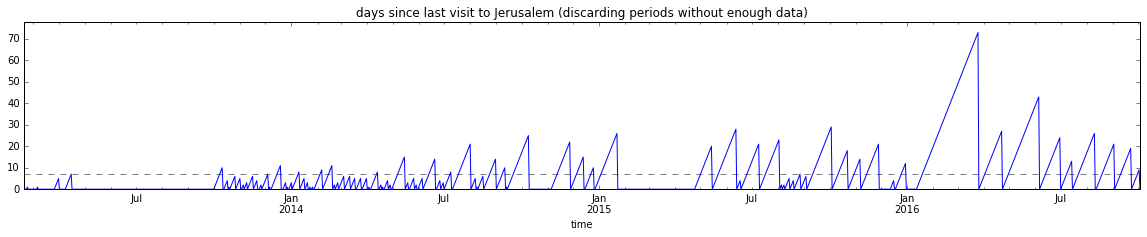

In [14]:
days_since_last_visit = count_days_since_most_recent_marker((is_jerusalem_daily == 1) | availability_on_switch)
days_since_last_visit *= data_availability

plt.ylim((0, days_since_last_visit.max() + 5))
plt.title('days since last visit to Jerusalem (discarding periods without enough data)')
days_since_last_visit.plot()

# if I don't come for 7 days in a row, it's ok by my parents
grace_period = 7
plt.hlines(y=grace_period,
           xmin=days_since_last_visit.index.min(),
           xmax=days_since_last_visit.index.max(),
           linestyles='--',
           color='gray')

I plotted an horizontal line symbolizing the *grace period* - the amount of time I don't visit and my parents are ok with it.

Let's analyze my parents sentiment regarding my visits frequency (which is occasionally above the grace period line).

My parents aren't robots. If I don't visit for a long time they get angry at me. And once I do visit they don't all of a sudden get happy; they hold a grudge. I'll model the grudge using a rolling window of width 30. It means that when analyzing some date, only the data available in the previous 30 days can affect the grudge.

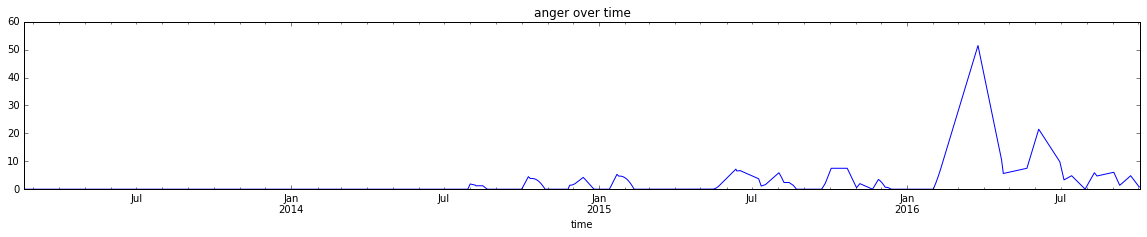

In [15]:
anger_with_grudge = days_since_last_visit.rolling(window=30).mean()
anger_with_grudge = (anger_with_grudge - grace_period).where(lambda anger_with_grudge: anger_with_grudge >= 0, other=0)
anger_with_grudge.plot.line()
plt.title('anger over time')

Let's do the same graph, but with colors and labels so I can present it to my parents:

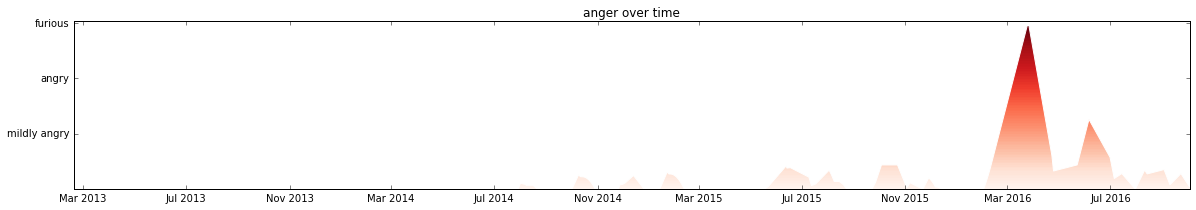

In [16]:
max_y = int(anger_with_grudge.values.max())
z = [[z] * len(anger_with_grudge.index) for z in range(max_y)]
plt.yticks(range(max_y / 3, max_y + 1, max_y / 3), ['mildly angry', 'angry', 'furious'])
plt.contourf(anger_with_grudge.index, range(max_y), z, 100, cmap='Reds')
plt.fill_between(x=anger_with_grudge.index, y1=anger_with_grudge.values, y2=max(anger_with_grudge.values), color='w')
plt.title('anger over time')

It seems like most of the time I'm kind of ok, and don't get my parents too upset with my visits frequency...

But there's that huge red pick! It occurred around the birth of my first child, so I think it's reasonable I didn't drive all the way to Jerusalem to pay a visit... And the joy of being grandparents might be greater than the grudge, so I'm ok there.

One more thing I didn't consider is the frequency of visits my parents conducted to Tel-Aviv. It's reasonable that I don't come to Jerusalem the day after they came visit me in Tel-Aviv. But I don't think my parents' phones have GPS turned on, so I can't extract their data...

---

To conclude:

Mother, father - if you're reading this, I hope you don't hold a grudge against me (or just didn't understand this analysis).